# Outline:
* [Configuration](#config)
* [Functions](#functions)
* [Loading-data](#loading-data)
* [Representation](#representation)

# Configuration <a class='anchor' id='config'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


url_csse_covid_19_daily_reports = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                   "csse_covid_19_data/csse_covid_19_daily_reports")
url_csse_covid_19_daily_reports_us = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                      "csse_covid_19_data/csse_covid_19_daily_reports_us")

url_time_series_covid19_confirmed_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
url_time_series_covid19_deaths_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
url_time_series_covid19_recovered_global = ("https://github.com/CSSEGISandData/COVID-19/raw/master/"
 "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

url_time_series_covid19_confirmed_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
url_time_series_covid19_deaths_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

yesterday = datetime.date.today() - datetime.timedelta(days=1)
url_apple_mobility_trends = ('https://covid19-static.cdn-apple.com/covid19-mobility-data/'
                             f'2009HotfixDev19/v3/en-us/applemobilitytrends-{yesterday}.csv')
url_google_mobility_report = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

# functions <a class='anchor' id='functions'></a>

In [2]:
def load_data(url):    
    import os
    from six.moves import urllib
    _, filename = url.rsplit('/', 1)
    filename = str(datetime.date.today()) + '_' + filename
    filepath = 'datasets/' + filename
    if not os.path.isdir('datasets'):
        os.makedirs('datasets')
    try:
        if not os.path.exists(filepath):
            urllib.request.urlretrieve(url, filepath)
    except:
        print('Could not retrieve ' + url)
        raise
    return pd.read_csv(filepath)

def format_columns(df):
    column_mapping = {'sub_region_1': 'province_state', 'sub_region_2': 'county', 'admin2': 'county',
                 'Country/Region':'country_region', 'Province/State': 'province_state', 'Long_': 'long'}
    df = df.rename(columns=column_mapping)    
    dates = {}
    names = {}
    for col in df.columns:
        try:
            dates[col] = pd.to_datetime(col).date()
        except:
            names[col] = str.lower(col)
    df = df.rename(columns=names).rename(columns=dates)
    cols_order = list(names.values()) + sorted(dates.values(), reverse=True)
    return df[cols_order]

def format_cells(df):
    df = df.copy()
    name_mapping = {'The Bahamas':'Bahamas', "Côte d'Ivoire":"Cote d'Ivoire", 'Myanmar (Burma)': 'Burma', 
                 'Korea, South': 'South Korea', 'Taiwan*':'Taiwan', 'US': 'United States'} 
    regex_mapping = {r'\s(p|P)rovince': '', r'\s(c|C)ounty': ''}
    df = df.replace(to_replace=name_mapping).replace(regex=regex_mapping)
    if 'population' in df.columns:
        df.loc[df['population'] <= 0, 'population'] = np.nan
    return df

def sparse_columns(df, sparsity_level=0.5):
    return df.columns[df.isna().sum() > df.shape[0] * sparsity_level].values


In [3]:
def get_google_mobility_data(url):
    df_mobility = load_data(url)
    df_mobility = format_cells(format_columns(df_mobility))
    df_mobility.loc[df_mobility['country_region'] == 'Aruba', 
                    ['country_region', 'province_state']] = ('Netherlands', 'Aruba')
    df_mobility.loc[df_mobility['country_region'] == 'Réunion', 
                    ['country_region', 'province_state']] = ('France', 'Réunion')
    df_mobility.loc[df_mobility['country_region'] == 'Hong Kong'
                    , ['country_region', 'province_state']] = ('China', 'Hong Kong')
    df_mobility['mobility'] = None
    cols = df_mobility.columns[-7:-1]
    df_mobility['mobility'] = df_mobility[cols].mean(axis=1)
    df_mob_1 = df_mobility[(~df_mobility['country_region'].isna()) & 
                       (~df_mobility['province_state'].isna()) & 
                       (~df_mobility['county'].isna())]
    df_mobility.drop(df_mob_1.index, inplace=True)
    df_mob_1 = (df_mob_1.pivot_table(values='mobility', index=['country_region', 'province_state', 'county'], columns='date')
            .reset_index())

    df_mob_2 = df_mobility[(~df_mobility['country_region'].isna()) & 
                       (~df_mobility['province_state'].isna()) & 
                       (df_mobility['county'].isna())]
    df_mobility.drop(df_mob_2.index, inplace=True)
    df_mob_2 = df_mob_2.pivot_table(values='mobility', index=['country_region', 'province_state'], columns='date').reset_index()

    df_mob_3 = df_mobility[(~df_mobility['country_region'].isna()) & 
                       (df_mobility['province_state'].isna()) & 
                       (df_mobility['county'].isna())]
    df_mobility.drop(df_mob_3.index, inplace=True)
    df_mob_3 = df_mob_3.pivot_table(values='mobility', index=['country_region'], columns='date').reset_index()
    df_mob = (df_mob_1.append(df_mob_2, sort=False)
              .append(df_mob_3, sort=False)
              .reset_index()
              .drop(columns='index')
              .set_index(['country_region', 'province_state', 'county']))
    return df_mob

# Loading data <a class='anchor' id='loading-data'></a>

**Fetch time series**

In [4]:
df_global_confirmed = load_data(url_time_series_covid19_confirmed_global)
df_global_deaths = load_data(url_time_series_covid19_deaths_global)
df_global_recovered = load_data(url_time_series_covid19_recovered_global)
df_us_confirmed = load_data(url_time_series_covid19_confirmed_US)
df_us_deaths= load_data(url_time_series_covid19_deaths_US)

df_global_confirmed = format_cells(format_columns(df_global_confirmed))
df_global_deaths = format_cells(format_columns(df_global_deaths))
df_global_recovered = format_cells(format_columns(df_global_recovered))
df_us_confirmed = format_cells(format_columns(df_us_confirmed))
df_us_deaths = format_cells(format_columns(df_us_deaths))

print('columns matched' if 
      df_global_confirmed.columns.symmetric_difference(df_global_deaths.columns).shape[0] == 0 and
      df_global_confirmed.columns.symmetric_difference(df_global_recovered.columns).shape[0] == 0
     else 'columns did not match')
print('columns matched' 
      if df_us_confirmed.columns.symmetric_difference(df_us_deaths.columns).shape[0] == 0
     else f'columns did not match: ({df_us_confirmed.columns.symmetric_difference(df_us_deaths.columns)})')

print(df_global_confirmed.shape, df_global_deaths.shape, df_global_recovered.shape)
print(df_us_confirmed.shape, df_us_deaths.shape)

columns matched
columns did not match: (Index(['population'], dtype='object'))
(266, 139) (266, 139) (253, 139)
(3261, 146) (3261, 147)


**Columns with lots of missing values:**

In [5]:
sparsity = 0.1
print(f'columns with at lease {sparsity * 100:.0f}% NA values:', sparse_columns(df_global_confirmed, sparsity))
print(f'columns with at lease {sparsity * 100:.0f}% NA values:', sparse_columns(df_global_deaths, sparsity))
print(f'columns with at lease {sparsity * 100:.0f}% NA values:', sparse_columns(df_global_recovered, sparsity))
print(f'columns with at lease {sparsity * 100:.0f}% NA values:', sparse_columns(df_us_confirmed, sparsity))
print(f'columns with at lease {sparsity * 100:.0f}% NA values:', sparse_columns(df_us_deaths, sparsity))

columns with at lease 10% NA values: ['province_state']
columns with at lease 10% NA values: ['province_state']
columns with at lease 10% NA values: ['province_state']
columns with at lease 10% NA values: []
columns with at lease 10% NA values: []


**Appending dataframes to make a single one:**

In [6]:
assert (('class' not in df_global_confirmed.columns) and 
        ('class' not in df_us_confirmed.columns.union(df_us_deaths.columns))), 'assignment to an existing column'

df_global_confirmed['class'] = 'confirmed'
df_global_deaths['class'] = 'deaths'
df_global_recovered['class'] = 'recovered'
df_global = (df_global_confirmed
             .append(df_global_deaths)
             .append(df_global_recovered)
             .set_index('country_region'))

df_us_confirmed['class'] = 'confirmed'
df_us_deaths['class'] = 'deaths'
df_us = (df_us_confirmed.append(df_us_deaths, sort=False))
df_us['country_region'] = 'United States'
df_us = df_us.set_index('country_region')

df = df_us.append(df_global, sort=False)
df = format_cells(format_columns(df))
df = df.reset_index().set_index(['class', 'country_region', 'province_state', 'county']).sort_index()

**Use slicer to access specific rows**

In [7]:
idx = pd.IndexSlice
df.loc[idx['confirmed', :, 'Oregon']].head(3)

uid           iso2  \
class     country_region province_state county                                 
confirmed United States  Oregon         Baker      84041001.0  United States   
                                        Benton     84041003.0  United States   
                                        Clackamas  84041005.0  United States   

                                                  iso3  code3     fips  \
class     country_region province_state county                           
confirmed United States  Oregon         Baker      USA  840.0  41001.0   
                                        Benton     USA  840.0  41003.0   
                                        Clackamas  USA  840.0  41005.0   

                                                         lat        long  \
class     country_region province_state county                             
confirmed United States  Oregon         Baker      44.709156 -117.674988   
                                        Benton     44.491673 -123.431699   
                                        Clackamas  45.187874 -122.217963   

                                                            combined_key  \
class     country_region province_state county                             
confirmed United States  Oregon         Baker          Baker, Oregon, US   
                                        Benton        Benton, Oregon, US   
                                        Clackamas  Clackamas, Oregon, US   

                                                   population  2020-06-04  \
class     country_region province_state county                              
confirmed United States  Oregon         Baker             NaN           1   
                                        Benton            NaN          57   
                                        Clackamas         NaN         333   

                                                   ...  2020-01-31  \
class     country_region province_state county     ...               
confirmed United States  Oregon         Baker      ...           0   
                                        Benton     ...           0   
                                        Clackamas  ...           0   

                                                   2020-01-30  2020-01-29  \
class     country_region province_state county                              
confirmed United States  Oregon         Baker               0           0   
                                        Benton              0           0   
                                        Clackamas           0           0   

                                                   2020-01-28  2020-01-27  \
class     country_region province_state county                              
confirmed United States  Oregon         Baker               0           0   
                                        Benton              0           0   
                                        Clackamas           0           0   

                                                   2020-01-26  2020-01-25  \
class     country_region province_state county                              
confirmed United States  Oregon         Baker               0           0   
                                        Benton              0           0   
                                        Clackamas           0           0   

                                                   2020-01-24  2020-01-23  \
class     country_region province_state county                              
confirmed United States  Oregon         Baker               0           0   
                                        Benton              0           0   
                                        Clackamas           0           0   

                                                   2020-01-22  
class     country_region province_state county                 
confirmed United States  Oregon         Baker               0  
                                        Benton     

In [8]:
df.loc[idx[:, 'Italy'],]

,,,,uid,iso2,iso3,code3,fips,lat,long,combined_key,population,2020-06-04,...,2020-01-31,2020-01-30,2020-01-29,2020-01-28,2020-01-27,2020-01-26,2020-01-25,2020-01-24,2020-01-23,2020-01-22
class,country_region,province_state,county,,,,,,,,,,,,,,,,,,,,,
confirmed,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,12.0,NaN,NaN,234013,...,2,0,0,0,0,0,0,0,0,0
deaths,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,12.0,NaN,NaN,33689,...,0,0,0,0,0,0,0,0,0,0
recovered,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,12.0,NaN,NaN,161895,...,0,0,0,0,0,0,0,0,0,0


**Fill mobility trends in different regions of the world**

In [9]:
# set(df_mobility['province_state'].unique()).difference(set(df.index.levels[1]))

In [10]:
# set(df.index.levels[2]).difference(set(df_mobility['province_state'].unique()))

In [11]:
df_mobility = get_google_mobility_data(url_google_mobility_report)

C:\Users\Abtin\Miniconda2\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
df_mobility

2020-02-15  2020-02-16  2020-02-17  \
country_region province_state county                                        
United States  Alabama        Autauga    2.666667   -6.500000   -3.500000   
                              Baldwin   16.000000    1.666667    9.000000   
                              Barbour   -0.666667   -5.000000   -4.333333   
                              Bibb       9.000000   -2.666667    0.000000   
                              Blount     5.333333    2.666667   -2.250000   
...                                           ...         ...         ...   
Venezuela      NaN            NaN        3.166667    2.000000    4.166667   
Vietnam        NaN            NaN       -4.500000   -6.000000   -3.833333   
Yemen          NaN            NaN        2.166667    2.333333    3.666667   
Zambia         NaN            NaN       -0.666667   -2.666667   -3.166667   
Zimbabwe       NaN            NaN       -2.500000   -4.500000   -0.666667   

                                       2020-02-18  2020-02-19  2020-02-20  \
country_region province_state county                                        
United States  Alabama        Autauga    0.000000    0.000000   -2.000000   
                              Baldwin    6.333333   12.000000    1.166667   
                              Barbour   -4.666667   -2.333333   -9.333333   
                              Bibb       1.333333   -1.333333   -3.666667   
                              Blount    -3.500000    1.500000   -1.000000   
...                                           ...         ...         ...   
Venezuela      NaN            NaN        1.500000    2.500000    4.833333   
Vietnam        NaN            NaN       -3.166667   -4.666667   -6.666667   
Yemen          NaN            NaN        2.666667    0.666667    2.500000   
Zambia         NaN            NaN       -1.500000   -3.166667   -5.666667   
Zimbabwe       NaN            NaN        1.333333   -1.166667    1.333333   

                                       2020-02-21  2020-02-22  2020-02-23  \
country_region province_state county                                        
United States  Alabama        Autauga   -0.500000    3.333333    2.666667   
                              Baldwin   17.500000   15.666667   25.000000   
                              Barbour   -0.666667   -1.000000   -0.333333   
                              Bibb       2.333333    7.666667   -3.000000   
                              Blount    -1.250000    6.000000    3.666667   
...                                           ...         ...         ...   
Venezuela      NaN            NaN        3.833333    7.000000   12.833333   
Vietnam        NaN            NaN       -6.000000   -4.333333   -5.333333   
Yemen          NaN            NaN        1.333333    4.000000    3.333333   
Zambia         NaN            NaN       -3.666667   -1.666667   -4.333333   
Zimbabwe       NaN            NaN      -21.000000   -4.833333   -3.000000   

                                       2020-02-24  ...  2020-05-20  \
country_region province_state county               ...               
United States  Alabama        Autauga   -1.000000  ...    2.750000   
                              Baldwin    3.333333  ...    6.833333   
                              Barbour   -2.333333  ...   -4.500000   
                              Bibb       3.333333  ...  -21.000000   
                              Blount    -1.000000  ...    0.000000   
...                                           ...  ...         ...   
Venezuela      NaN            NaN      -10.833333  ...  -32.333333   
Vietnam        NaN            NaN       -2.166667  ...   -4.166667   
Yemen          NaN            NaN        4.500000  ...   -3.000000   
Zambia         NaN            NaN       -4.833333  ...   -4.333333   
Zimbabwe       NaN            NaN       -4.833333  ...  -17.500000   

                                       2020-05-21  2020-05-22  2020-05-23  \
country_region province_state county         

Inserting mobility data into our main dataframe

In [13]:
unique_places_in_df = set(x[1:] for x in df.index.values)
unique_places_in_df_mobility = set(df_mobility.index.values)
index_to_be_used = unique_places_in_df.intersection(unique_places_in_df_mobility)
index_to_be_used = pd.Index(index_to_be_used)
df_mobility  = (df_mobility.loc[index_to_be_used]
                .reset_index()
                .rename(columns={'level_0': 'country_region', 'level_1': 'province_state', 'level_2': 'county'}))
df_mobility['class'] = 'mobility'
df_mobility = df_mobility.set_index(['class', 'country_region', 'province_state', 'county'])
df = df.append(df_mobility, sort=True)

In [14]:
df.loc[idx[:, 'Italy', :, :],]

,,,,code3,combined_key,fips,iso2,iso3,lat,long,population,uid,2020-06-04,...,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29
class,country_region,province_state,county,,,,,,,,,,,,,,,,,,,,,
confirmed,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,12.0,NaN,NaN,234013.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deaths,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,12.0,NaN,NaN,33689.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recovered,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,12.0,NaN,NaN,161895.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobility,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-23.5,-20.0,-19.166667,-15.833333,-17.833333,-18.666667,-17.666667,-16.833333,-17.0,-19.666667


**Fill missing population fields:**

In [15]:
s1 = df.loc[df['population'] > 0, 'population']
s2index = pd.MultiIndex.from_tuples([('confirmed', *ind[1:]) for ind in s1.index])
s3index = pd.MultiIndex.from_tuples([('recovered', *ind[1:]) for ind in s1.index])
s2 = pd.Series(s1.values, index=s2index)
s3 = pd.Series(s1.values, index=s3index)
s = s1.append(s2).append(s3)
df['population'] = s

In [16]:
df.loc[idx[:,:,'Oregon', 'Benton'],]

,,,,code3,combined_key,fips,iso2,iso3,lat,long,population,uid,2020-06-04,...,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29
class,country_region,province_state,county,,,,,,,,,,,,,,,,,,,,,
confirmed,United States,Oregon,Benton,840.0,"Benton, Oregon, US",41003.0,United States,USA,44.491673,-123.431699,93053.0,84041003.0,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deaths,United States,Oregon,Benton,840.0,"Benton, Oregon, US",41003.0,United States,USA,44.491673,-123.431699,93053.0,84041003.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobility,United States,Oregon,Benton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.666667,-16.0,-15.666667,-4.166667,-8.4,-33.0,-6.5,-23.2,-6.0,-10.833333


In [17]:
set((x[1:]) for x in df[df['population'].isna()].index)

{('United States', 'Indiana', 'Knox'),
 ('United States', 'Minnesota', 'Stearns'),
 ('United States', 'Oklahoma', 'Coal'),
 ('Slovakia', nan, nan),
 ('United States', 'Hawaii', 'Honolulu'),
 ('United States', 'Oklahoma', 'McIntosh'),
 ('United States', 'Georgia', 'Camden'),
 ('United States', 'Missouri', 'Moniteau'),
 ('United States', 'Texas', 'Llano'),
 ('United States', 'New Mexico', 'Guadalupe'),
 ('United States', 'Texas', 'Jim Hogg'),
 ('United States', 'Texas', 'Oldham'),
 ('United States', 'Illinois', 'Franklin'),
 ('United States', 'Tennessee', 'McNairy'),
 ('United States', 'Iowa', 'Fayette'),
 ('Western Sahara', nan, nan),
 ('United States', 'New Jersey', 'Bergen'),
 ('United States', 'West Virginia', 'Mercer'),
 ('United States', 'Iowa', 'Mitchell'),
 ('United States', 'Michigan', 'Bay'),
 ('United States', 'Iowa', 'Marion'),
 ('United States', 'Indiana', 'Cass'),
 ('United States', 'Alaska', 'Anchorage'),
 ('United States', 'North Carolina', 'Montgomery'),
 ('United States

**Find the date columns**

In [18]:
from datetime import date
cols_date = sorted([x for x in df.columns if isinstance(x, date)])
print(f'date range: {min(cols_date)} to {max(cols_date)}')

date range: 2020-01-22 to 2020-06-04


# Representation <a class='anchor' id='representation'></a>

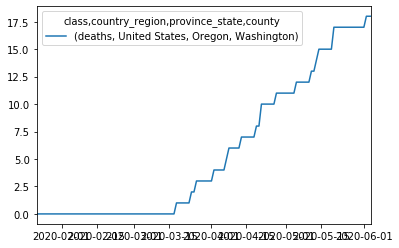

In [19]:
df.loc[idx['deaths', :, 'Oregon', 'Washington'], cols_date].T.plot()

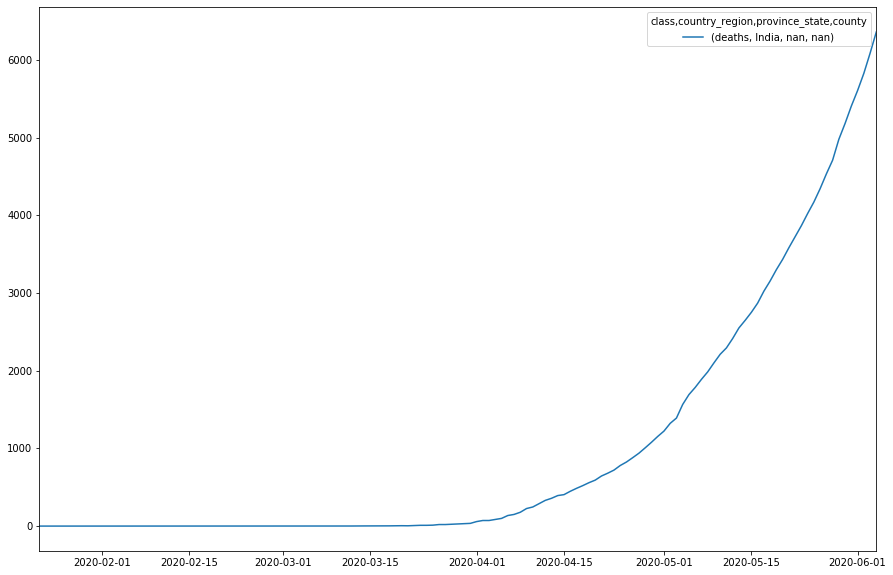

In [20]:
df.loc[idx['deaths', 'India', :, :], cols_date].T.plot(figsize=(15,10))